In [1]:
# Import libraries and set desired options
import pickle
from pathlib2 import Path
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
%config InlineBackend.figure_format = 'retina'

In [2]:
import os
os.getcwd()

'C:\\Users\\Рудольф\\Notebook_files\\mlcourse.ai\\my_work'

In [3]:
# Read the training and test data sets, change paths if needed
#PATH_TO_DATA = Path('/Assignment-3/data/')
PATH_TO_DATA = Path('C:/Users/Рудольф/Notebook_files/mlcourse.ai/my_work/Assignment-3/data/telecom_churn.csv')

times = ['time%s' % i for i in range(1, 11)]
train_df = pd.read_csv(PATH_TO_DATA / 'train_sessions.csv',
                       index_col='session_id', parse_dates=times)
test_df = pd.read_csv(PATH_TO_DATA / 'test_sessions.csv',
                      index_col='session_id', parse_dates=times)

# Sort the data by time
train_df = train_df.sort_values(by='time1')

# Look at the first rows of the training set
train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55.0,2013-01-12 08:05:57,NaN,NaT,NaN,NaT,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
54843,56,2013-01-12 08:37:23,55.0,2013-01-12 08:37:23,56.0,2013-01-12 09:07:07,55.0,2013-01-12 09:07:09,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
77292,946,2013-01-12 08:50:13,946.0,2013-01-12 08:50:14,951.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:16,...,2013-01-12 08:50:16,948.0,2013-01-12 08:50:16,784.0,2013-01-12 08:50:16,949.0,2013-01-12 08:50:17,946.0,2013-01-12 08:50:17,0
114021,945,2013-01-12 08:50:17,948.0,2013-01-12 08:50:17,949.0,2013-01-12 08:50:18,948.0,2013-01-12 08:50:18,945.0,2013-01-12 08:50:18,...,2013-01-12 08:50:18,947.0,2013-01-12 08:50:19,945.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:20,0
146670,947,2013-01-12 08:50:20,950.0,2013-01-12 08:50:20,948.0,2013-01-12 08:50:20,947.0,2013-01-12 08:50:21,950.0,2013-01-12 08:50:21,...,2013-01-12 08:50:21,946.0,2013-01-12 08:50:21,951.0,2013-01-12 08:50:22,946.0,2013-01-12 08:50:22,947.0,2013-01-12 08:50:22,0


In [4]:
# Change site1, ..., site10 columns type to integer and fill NA-values with zeros
sites = ['site%s' % i for i in range(1, 11)]
train_df[sites] = train_df[sites].fillna(0).astype(np.uint16)
test_df[sites] = test_df[sites].fillna(0).astype(np.uint16)

# Load websites dictionary
with open(PATH_TO_DATA / 'site_dic.pkl', "rb") as input_file:
    site_dict = pickle.load(input_file)

# Create dataframe for the dictionary
sites_dict = pd.DataFrame(list(site_dict.keys()), index=list(site_dict.values()), 
                          columns=['site'])
print(u'Websites total:', sites_dict.shape[0])
sites_dict.head()

Websites total: 48371


,site
25075,www.abmecatronique.com
13997,groups.live.com
42436,majeureliguefootball.wordpress.com
30911,cdt46.media.tourinsoft.eu
8104,www.hdwallpapers.eu


In [5]:
# Top websites in the training data set
top_sites = pd.Series(train_df[sites].values.flatten()
                     ).value_counts().sort_values(ascending=False).head(5)
print(top_sites)
sites_dict.loc[top_sites.drop(0).index]

21     123776
0      122730
23      87619
782     77055
22      58258
dtype: int64


,site
21,www.google.fr
23,www.google.com
782,annotathon.org
22,apis.google.com


#### 1. What kind of sites does Alice visit the most?

In [6]:
alice_sites = pd.Series(train_df[train_df['target'] == 1][sites].values.flatten()
                     ).value_counts().sort_values(ascending=False).head(5)
print(alice_sites)
sites_dict.loc[alice_sites.index]

77    1382
80    1354
76    1307
29     897
21     857
dtype: int64


,site
77,i1.ytimg.com
80,s.youtube.com
76,www.youtube.com
29,www.facebook.com
21,www.google.fr


#### Answer: 1 - videohostings

In [7]:
# Create a separate dataframe where we will work with timestamps
time_df = pd.DataFrame(index=train_df.index)
time_df['target'] = train_df['target']

# Find sessions' starting and ending
time_df['min'] = train_df[times].min(axis=1)
time_df['max'] = train_df[times].max(axis=1)

# Calculate sessions' duration in seconds
time_df['seconds'] = (time_df['max'] - time_df['min']) / np.timedelta64(1, 's')

time_df.head()

,target,min,max,seconds
session_id,,,,
21669,0,2013-01-12 08:05:57,2013-01-12 08:05:57,0.0
54843,0,2013-01-12 08:37:23,2013-01-12 09:07:09,1786.0
77292,0,2013-01-12 08:50:13,2013-01-12 08:50:17,4.0
114021,0,2013-01-12 08:50:17,2013-01-12 08:50:20,3.0
146670,0,2013-01-12 08:50:20,2013-01-12 08:50:22,2.0


#### Question 2.

In [8]:
time_df.describe()

,target,seconds
count,253561.000000,253561.000000
mean,0.009059,138.494370
std,0.094747,295.781742
min,0.000000,0.000000
25%,0.000000,7.000000
50%,0.000000,27.000000
75%,0.000000,113.000000
max,1.000000,1800.000000


In [9]:
time_df[time_df['target'] == 1].describe()

,target,seconds
count,2297.0,2297.000000
mean,1.0,52.296474
std,0.0,153.309014
min,1.0,0.000000
25%,1.0,4.000000
50%,1.0,11.000000
75%,1.0,38.000000
max,1.0,1763.000000


In [10]:
(1800-1763)/1800

0.020555555555555556

#### Answer: 1, 3, 5

In [11]:
# Our target variable
y_train = train_df['target']

# United dataframe of the initial data 
full_df = pd.concat([train_df.drop('target', axis=1), test_df])

# Index to split the training and test data sets
idx_split = train_df.shape[0]

In [12]:
# Dataframe with indices of visited websites in session
full_sites = full_df[sites]
full_sites.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10
session_id,,,,,,,,,,
21669,56,55,0,0,0,0,0,0,0,0
54843,56,55,56,55,0,0,0,0,0,0
77292,946,946,951,946,946,945,948,784,949,946
114021,945,948,949,948,945,946,947,945,946,946
146670,947,950,948,947,950,952,946,951,946,947


In [13]:
full_sites.values.flatten()


array([  56,   55,    0, ..., 1098, 1098, 1098], dtype=uint16)

In [14]:
# sequence of indices
sites_flatten = full_sites.values.flatten()

# and the matrix we are looking for 
# (make sure you understand which of the `csr_matrix` constructors is used here)
# a further toy example will help you with it
full_sites_sparse = csr_matrix(([1] * sites_flatten.shape[0],
                                sites_flatten,
                                range(0, sites_flatten.shape[0]  + 10, 10)))[:, 1:]

In [15]:
full_sites_sparse.shape

(336358, 48371)

#### Question 3. What is the sparsity of the matrix in our small example?

##### Answer: 3 - 50%

## Train the first model

In [16]:
def get_auc_lr_valid(X, y, C=1.0, seed=17, ratio = 0.9):
    # Split the data into the training and validation sets
    idx = int(round(X.shape[0] * ratio))
    # Classifier training
    lr = LogisticRegression(C=C, random_state=seed, solver='liblinear').fit(X[:idx, :], y[:idx])
    # Prediction for validation set
    y_pred = lr.predict_proba(X[idx:, :])[:, 1]
    # Calculate the quality
    score = roc_auc_score(y[idx:], y_pred)
    
    return score

In [17]:
%%time
# Select the training set from the united dataframe (where we have the answers)
X_train = full_sites_sparse[:idx_split, :]

# Calculate metric on the validation set
print(get_auc_lr_valid(X_train, y_train))

0.9195241058359781
Wall time: 7.14 s


In [18]:
# Function for writing predictions to a file
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [19]:
# Train the model on the whole training data set
# Use random_state=17 for repeatability
# Parameter C=1 by default, but here we set it explicitly
X_train = full_sites_sparse[:idx_split, :]

lr = LogisticRegression(C=1.0, random_state=17, solver='liblinear').fit(X_train, y_train)

# Make a prediction for test data set
X_test = full_sites_sparse[idx_split:,:]
y_test = lr.predict_proba(X_test)[:, 1]

# Write it to the file which could be submitted
write_to_submission_file(y_test, 'baseline_1.csv')

## Model improvement. Feature engineering

In [20]:
# Dataframe for new features
full_new_feat = pd.DataFrame(index=full_df.index)

# Add start_month feature
full_new_feat['start_month'] = full_df['time1'].apply(lambda ts: 
                                                      100 * ts.year + ts.month).astype('float64')

### Question 4. Plot the graph of the number of Alice sessions versus the new feature, start_month. 

In [21]:
full_new_feat.head(4)

,start_month
session_id,
21669,201301.0
54843,201301.0
77292,201301.0
114021,201301.0


In [22]:
sessions = train_df[train_df['target'] == 1].index
sessions_dates = full_new_feat.iloc[sessions]
sessions_dates = sessions_dates.start_month.astype('category').values
sessions_dates.describe()

,counts,freqs
categories,,
201301.0,2,0.000871
201302.0,29,0.012625
201303.0,32,0.013931
201304.0,39,0.016979
201305.0,28,0.012190
201306.0,15,0.006530
201308.0,3,0.001306
201309.0,32,0.013931
201310.0,31,0.013496


In [23]:
#np.unique(sessions_dates)
dates, numbers = np.unique(sessions_dates, return_counts = True)
dates.astype(str).dtype
#numbers

dtype('<U32')

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
 <a list of 15 Text xticklabel objects>)

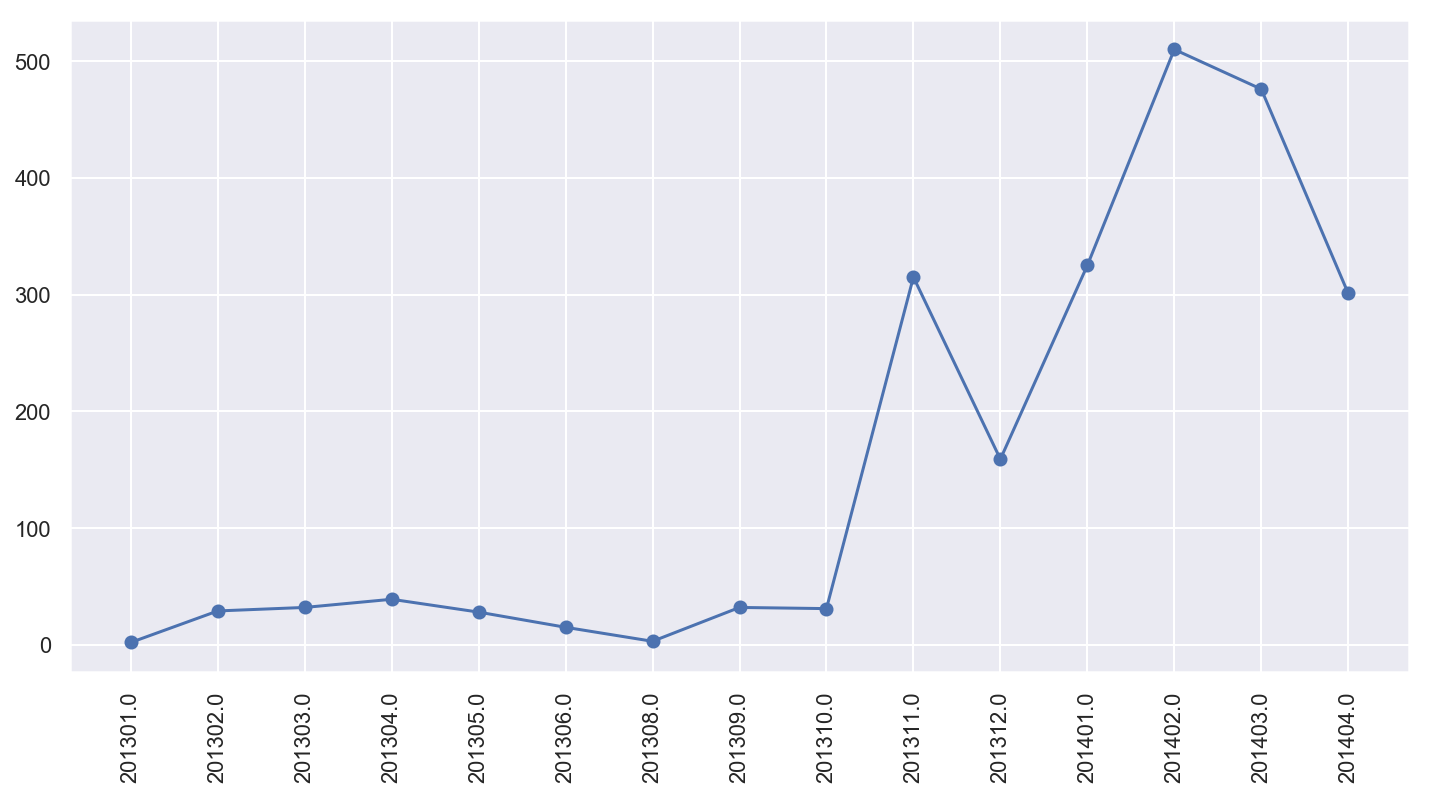

In [24]:
plt.figure(figsize = [12, 6])
plt.plot(dates.astype(str), numbers, '-o')
plt.xticks(rotation='vertical')

#### Answer: 4.

In [25]:
# Add the new feature to the sparse matrix
tmp = full_new_feat[['start_month']].values
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], tmp[:idx_split,:]]))

# Compute the metric on the validation set
print(get_auc_lr_valid(X_train, y_train))

0.7508354860175162


In [26]:
# Add the new standardized feature to the sparse matrix
tmp = StandardScaler().fit_transform(full_new_feat[['start_month']])
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], tmp[:idx_split,:]]))

# Compute metric on the validation set
print(get_auc_lr_valid(X_train, y_train))

0.9196986151568289


### Question 5. Add to the training set a new feature "n_unique_sites" – the number of the unique web-sites in a session. Calculate how the quality on the validation set has changed

In [27]:
full_new_feat['n_unique_sites'] = full_sites_sparse.getnnz(axis=1)

In [28]:
n_unique = full_new_feat[['n_unique_sites']].values

In [29]:
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], tmp[:idx_split,:], n_unique[:idx_split]]))

In [30]:
print(get_auc_lr_valid(X_train, y_train))

0.9140999757256931


In [31]:
n_unique = StandardScaler().fit_transform(full_new_feat[['n_unique_sites']])
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], tmp[:idx_split,:], n_unique[:idx_split]]))
print(get_auc_lr_valid(X_train, y_train))

C:\anaconda\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int32 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\anaconda\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int32 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


0.9161136260983822


#### Answer: 4.

### Question 6.  Add two new features: start_hour and morning. Calculate the metric. Which of these features gives an improvement?

In [32]:
time_df.head(5)

,target,min,max,seconds
session_id,,,,
21669,0,2013-01-12 08:05:57,2013-01-12 08:05:57,0.0
54843,0,2013-01-12 08:37:23,2013-01-12 09:07:09,1786.0
77292,0,2013-01-12 08:50:13,2013-01-12 08:50:17,4.0
114021,0,2013-01-12 08:50:17,2013-01-12 08:50:20,3.0
146670,0,2013-01-12 08:50:20,2013-01-12 08:50:22,2.0


In [33]:
time_df['min'].iloc[0].hour

8

In [34]:
full_new_feat['start_hour'] = [i.hour for i in full_df['time1']]
full_new_feat['start_hour'].head(5)

session_id
21669     8
54843     8
77292     8
114021    8
146670    8
Name: start_hour, dtype: int64

In [35]:
np.shape([full_new_feat['start_hour'] <= 11])

(1, 336358)

In [36]:
morning = np.reshape([full_new_feat['start_hour'] <= 11], 336358)

In [37]:
full_new_feat['morning'] = morning.astype(int)
morn = full_new_feat[['morning']].values
full_new_feat['morning'].head(5)


session_id
21669     1
54843     1
77292     1
114021    1
146670    1
Name: morning, dtype: int32

In [38]:
start_hour = StandardScaler().fit_transform(full_new_feat[['start_hour']])
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], tmp[:idx_split,:], start_hour[:idx_split]]))
print(get_auc_lr_valid(X_train, y_train))

C:\anaconda\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\anaconda\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


0.9579249120811173


In [39]:
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], tmp[:idx_split,:], morn[:idx_split]]))
print(get_auc_lr_valid(X_train, y_train))

0.9486683700950201


In [40]:
start_hour = StandardScaler().fit_transform(full_new_feat[['start_hour']])
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], tmp[:idx_split,:], start_hour[:idx_split], 
                            morn[:idx_split,:]]))
print(get_auc_lr_valid(X_train, y_train))

C:\anaconda\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\anaconda\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


0.9591194555550725


#### Answer: 4. both features gave an improvment

In [41]:
# Compose the training set
tmp_scaled = StandardScaler().fit_transform(full_new_feat[['start_month', 
                                                           'start_hour', 
                                                           'morning']])
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], 
                             tmp_scaled[:idx_split,:]]))

# Capture the quality with default parameters
score_C_1 = get_auc_lr_valid(X_train, y_train)
print(score_C_1)

C:\anaconda\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\anaconda\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


0.9591526666714973


In [42]:
#%%time
# List of possible C-values
Cs = np.logspace(-3, 1, 10)

# You code here

valid_scores = [get_auc_lr_valid(X_train, y_train, C) for C in Cs]

print(Cs)
print(valid_scores)

[1.00000000e-03 2.78255940e-03 7.74263683e-03 2.15443469e-02
 5.99484250e-02 1.66810054e-01 4.64158883e-01 1.29154967e+00
 3.59381366e+00 1.00000000e+01]
[0.8229644453864324, 0.8965353710466695, 0.9390416751204054, 0.9563605175378849, 0.9606927567158916, 0.9612125106879411, 0.9603245662024357, 0.9586709545237164, 0.9557590944113541, 0.9513251084493911]


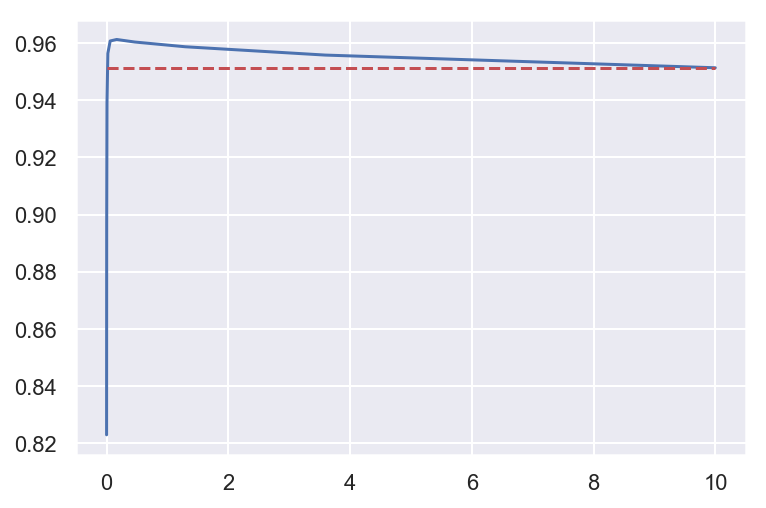

In [43]:
plt.plot(Cs, valid_scores)
plt.plot(Cs, [valid_scores[-1]]*10, '--r')
#print(valid_scores)

### Question 7. What is the value of parameter C (if rounded to 2 decimals) that corresponds to the highest model quality?

#### Answer: 1 - 0.17

In [44]:
C = Cs[5]
C

0.1668100537200059

In [45]:
# Prepare the training and test data
tmp_scaled = StandardScaler().fit_transform(full_new_feat[['start_month', 'start_hour', 
                                                           'morning']])
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], 
                             tmp_scaled[:idx_split,:]]))
X_test = csr_matrix(hstack([full_sites_sparse[idx_split:,:], 
                            tmp_scaled[idx_split:,:]]))

# Train the model on the whole training data set using optimal regularization parameter
lr = LogisticRegression(C=C, random_state=17, solver='liblinear').fit(X_train, y_train)

# Make a prediction for the test set
y_test = lr.predict_proba(X_test)[:, 1]

# Write it to the submission file
write_to_submission_file(y_test, 'baseline_2_2.csv')

C:\anaconda\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\anaconda\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
